# Part 0:
## import everything
Run the cell below

In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
from scipy import stats
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib.animation as animation
import matplotlib.backends.backend_pdf
import mpl_toolkits.axes_grid1.inset_locator as inset
from matplotlib.ticker import FormatStrFormatter, MaxNLocator, ScalarFormatter, FuncFormatter
from matplotlib.patches import ConnectionPatch, FancyArrowPatch
from set_rc_params import set_rc_params
import ROOT


if "__file__" not in dir():
    %matplotlib inline
    %config InlineBackend.close_figures = False

    root=ROOT.root
    
    ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
    CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
    CWD=os.getcwd()
    os.chdir(CommonNoteBookesPath)
    %run UtilityTools.ipynb
    %run Animal_Tags.ipynb
    %run loadRat_documentation.ipynb
    %run Lesion_Size.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb
    %run plotRat_documentation_3_KinematicsInvestigation.ipynb
    %run RunBatchRat_3_CompareGroups.ipynb
    %run BatchRatBehavior.ipynb
    currentNbPath=os.path.join(os.path.split(ThisNoteBookPath)[0],'LesionPaper','Task_Behavior.ipynb')
    %run $currentNbPath

    os.chdir(CWD)

    logging.getLogger().setLevel(logging.ERROR)
    
    param={
        "goalTime":7,#needed for pavel data only
        "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
        "maxTrialDuration":15,
        "interTrialDuration":10,#None pavel
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "cameraSamplingRate":25, #needed for new setup    

        "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
        "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
        "nbJumpMax":100,#200 pavel
        "binSize":0.25,
        #parameters used to preprocess (will override the default parameters)
    }
    Y1,Y2=param['treadmillRange']

    print('os:',OS(),'\nroot:',root,'\nImport successful!')

---
---


# part 1:

# DEFINITIONS

### If you don't know what to do, move to part 2

---

plotting group bar plots

In [ ]:
def plot_event_rec(root, ax, Profiles, badAnimals=None, TaskParamToPlot='% good trials', shift=0,
                   nPre=5, nPost=10, **kwarg):

    if badAnimals is None:
        badAnimals=[]
    
    #getting the data
    animalList,SessionDict=event_detect(root, Profiles[0], Profiles[1], badAnimals=badAnimals)
    SessionDict={animal:SessionDict[animal] for animal in animalList}
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                      SessionDict,
                                                      parameter=param,
                                                      redo=False,
                                                      TaskParamToPlot=[TaskParamToPlot])

    assert nPre<=nSessionPre and nPost<=nSessionPost,"fewer sessions available than requested:"
    
    data=np.array(list(Results[TaskParamToPlot].values()))
    
    xData=np.append(np.arange(-nPre,0),np.arange(1,nPost+1))

    groupData=np.nanmedian(data,axis=0)
    
    groupErr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(xData + shift, groupData[nSessionPre-nPre:nSessionPre+nPost],
                abs(groupErr-groupData)[:,nSessionPre-nPre:nSessionPre+nPost],
                fmt='-o', zorder=5, ms=2, elinewidth=1,alpha=.8, **kwarg)
    
    def _tik(x,pos):
        if x in [-nPre,-1,1,nPost]:
            return ('%+g' if x>0 else '%g')%x
        else:
            return ''
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(_tik))
    
    ax.set_xlim([-nPre-.3,nPost+.3])
    ax.spines['bottom'].set_bounds(-nPre,nPost)
    ax.set_xticks(xData)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0,100])
    ax.set_ylabel(TaskParamToPlot)
#     ax.set_xlabel('Sessions relative to break / lesion')

    return data[:,nSessionPre]


def add_legend_for_lesion_types(ax,N):
    r_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='xkcd:red', marker='o',
                                       markerfacecolor='xkcd:red', markersize=3, label=f'DLS\n$n={N[0]}$')
    b_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='xkcd:blue', marker='o',
                                       markerfacecolor='xkcd:blue', markersize=3, label=f'DMS\n$n={N[1]}$')
    m_marker = matplotlib.lines.Line2D([], [], color=[0,0,0,0],
                                       markeredgecolor='xkcd:magenta', marker='o',
                                       markerfacecolor='xkcd:magenta', markersize=3, label=f'DS\n$n={N[2]}$')


    leg=ax.legend(handles=[r_marker,b_marker,m_marker],loc=(0,.07),mode='expand',ncol=3,
                  facecolor=None,edgecolor=None, fontsize='xx-small',frameon=False)
    return leg

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control','Control-BackTo10','Control-Late-BackTo10']
              }
    profile2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control-AfterBreak']
              }

    #number of sessions to plot
    badAnimals=['RatBAD']
    TaskParamToPlot="% good trials"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    a=plot_event_rec(root, ax, Profiles,color='k',shift=-.1*.25)
    ax.set_ylim([0,100])

---

plotting group double errorbars for speed 

In [ ]:
def plot_event_1on1(root, ax, Profiles, colorCode, badAnimals=None, TaskParamToPlot='% good trials',
                   x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                    seed=1, animal_plot=True):
    if badAnimals is None:
        badAnimals=[]
    
    if x_pos is None:
        diff=.35
        x_c=ax.get_xlim()[1]
        x_pos=(x_c-diff,x_c+diff,x_c+3*diff)
    diff=x_pos[1]-x_pos[0]
    
    #getting the data
    animalList,sessionDict=event_detect(root, Profiles[0], Profiles[1], badAnimals=badAnimals)
    
    data=np.empty((len(animalList),3))
    for i,animal in enumerate(animalList):
        preSession,postSession=sessionDict[animal][0], sessionDict[animal][1]
        out=animal_learning_stats(root, animal, PerfParam=TaskParamToPlot,
                                  goodSessions=[*preSession,*postSession],redo=False)
        
        data[i,0]=np.nanmedian(out[:len(preSession)][nPre])
        data[i,1]=np.nanmedian(out[len(preSession):][nPost])
        data[i,2]=np.nanmedian(out[len(preSession):][nFin])
        
            
    
    y=np.nanpercentile(data,50,axis=0)
    yerr=np.nanpercentile(data,(25,75),axis=0)
    
    #plotting the errorbar
    ax.errorbar(x_pos, y, abs(yerr-y),fmt='o', zorder=5, ms=2, elinewidth=1, color='k')
    
    #plotting individual animals
    if animal_plot:
        np.random.seed(seed=seed)
        _coeff=5
        for i in range(data.shape[0]):
            if np.any(np.isnan(data[i,:])):
                continue
            jitPre =np.random.uniform(low=x_pos[0]-diff/_coeff, high=x_pos[0]+diff/_coeff, size=1)
            jitPost=np.random.uniform(low=x_pos[1]-diff/_coeff, high=x_pos[1]+diff/_coeff, size=1)
            jitFin =np.random.uniform(low=x_pos[2]-diff/_coeff, high=x_pos[2]+diff/_coeff, size=1)
            
            _,tag=lesion_type(root,animalList[i])
            c=colorCode[tag] if tag in colorCode else 'gray'
            ax.scatter([jitPre,jitPost,jitFin],data[i,:], s=1, c=c, marker='o', edgecolors='none', alpha=.8)
            ax.plot([jitPre,jitPost,jitFin],data[i,:], c=c, lw=.2, alpha=.4)
#             ax.plot([jitPre,jitFin],data[i,[0,-1]], c=c, lw=.2, alpha=.4)

    ax.set_xlim([x_pos[0]-diff/2,x_pos[-1]+diff/2])
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Before','After','Final'])
    ax.xaxis.set_tick_params(rotation=0)
    ax.spines['bottom'].set_bounds(x_pos[0],x_pos[-1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.set_ylabel(TaskParamToPlot)
#     ax.set_xlabel('Sessions relative to lesion')

    return data,animalList

In [ ]:
if "__file__" not in dir():

    profile1={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout',
              'Control-NoTimeout-Control','Control-Sharp','IncReward-Late-Sharp',
              'Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
             }
    profile2={'Type':'Good',
             'rewardType':'Progressive',
             'initialSpeed':['0','10'],
             'Speed':'10',
             'Tag':['Late-Lesion_DLS','Late-Lesion_DMS','Late-Lesion_DS',
                    'Late-Lesion_DS-Sharp','Late-Lesion_DMS-Sharp']
             }

    #number of sessions to plot
    badAnimals=['RatBAD']
    TaskParamToPlot="% good trials"
    wspace=0.05
    
    
    Profiles=(profile1,profile2,)
    plt.close('all')
    fig=plt.figure(figsize=(5,4))
    ax=fig.add_subplot(111)

    ax.set_xticks([])
    plot_event_1on1(root, ax, Profiles, colorCode={'Control':'r'}, badAnimals=None, TaskParamToPlot=TaskParamToPlot,
                       x_pos=None, nPre=slice(-3,None), nPost=slice(0,3),nFin=slice(3,6),
                        seed=1, animal_plot=True)

---

Plot the definition of before after ...

In [ ]:
def plot_session_def(ax, sessionSlices= tuple()):
    eps=0
    xpos=ax.get_xticks()
    
    for sli in sessionSlices:
        assert isinstance(sli, slice), 'Bad Boy!'        
        stop=sli.stop
        if stop is None:
            stop=-1
        start=sli.start
        if start>=0:
            start+=1
#             stop+=1
        
        ax.axvspan(xmin=start+eps, xmax=stop-eps, zorder=-1, alpha=.6, ec= None,
                  color='xkcd:ivory')
        
    if len(sessionSlices)==3:
        for sli,string in zip(sessionSlices,['Before','After','Final']):
            stop=sli.stop
            if stop is None:
                stop=-1
            start=sli.start
            if start>=0:
                start+=1
            
            mid=(start+stop)/2
            
            ax.text(mid,ax.get_ylim()[1],s=string,
                   fontsize='x-small', ha='center',va='top')

In [ ]:
if "__file__" not in dir():

    plt.close('all')
    fig=plt.figure(figsize=(5,5))
    ax=fig.add_subplot(111)
    
    preSlice=slice(-3,None)
    postSlice=slice(0,3)
    finSlice=slice(3,6)
    
    SLICES=(preSlice,postSlice,finSlice)
    
    plt.xlim([-6,11])
    plot_session_def(ax,SLICES)
    

------



------

# part 2:

# GENERATING THE FIGURE

Definition of Parameters

In [ ]:
if "__file__" not in dir():
    # GENERAL PARAMS
    
    CtrlColor='gray'
    DLSColor='xkcd:red'
    DMSColor='xkcd:blue'
    DSColor='xkcd:magenta'
    
    ColorCode={'DS':DSColor,
               'DMS':DMSColor,
               'DLS':DLSColor,
               'Control':CtrlColor
              }
    
    
    #===============================================
    
    # GRID 2 PARAMS
    
    TaskParamToPlot2='median entrance time (sec)'
    nPre2=5
    nPost2=10
    _s=.1
    ShiftDLS2 =-_s
    ShiftDMS2 =0*_s
    ShiftDS2  =_s
    
    
    profileCtrlPre2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control','1Control-BackTo10','1Control-Late-BackTo10']
              }
    profileCtrlPost2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':'10',
              'Speed':'10',
              'Tag':['Control-AfterBreak']
              }  
    ProfilesCtrl2=(profileCtrlPre2,profileCtrlPost2,)
    
    profilePreLesion2={'Type':'Good',
              'rewardType':'Progressive',
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Control', 'Control-AfterBreak', 'Control-Late-NoTimeout-BackToTimeout', 'Control-NoTimeout-Control',
                     'Control-Sharp','IncReward-Late-Sharp','Control-Sharp-AfterBreak','ImmobileTreadmill-Control']
              }
    
    profileDLS2={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DLS']
                 }
    profileDMS2={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DMS','Late-Lesion_DMS-Sharp'],
                 }  
    profileDS2={'Type':'Good',
              'rewardType':'Progressive',
              'option':['not used', 'AsymmetricLesion'],
              'initialSpeed':['10','0'],
              'Speed':'10',
              'Tag':['Late-Lesion_DS','Late-Lesion_DS-Sharp']
                 }  

    ProfilesDLS2=(profilePreLesion2,profileDLS2,)
    ProfilesDMS2=(profilePreLesion2,profileDMS2,)
    ProfilesDS2 =(profilePreLesion2,profileDS2,)

    
    #================================================
    
    # GRID 3 PARAMS

    profileLesions3={'Type':'Good',
                     'rewardType':'Progressive',
                     'option':['not used', 'AsymmetricLesion'],
                     'initialSpeed':['0','10'],
                     'Speed':'10',
                     'Tag': list(set((*profileDLS2['Tag'], *profileDMS2['Tag'], *profileDS2['Tag'])))
                     }

    Profiles3=(profilePreLesion2,profileLesions3)
    TaskParamToPlot3="Forward Running Speed"
    preSlice3=slice(-3,None)
    postSlice3=slice(0,3)
    finSlice3=slice(7,10)
    
    


    #================================================
    
    # GRID 4 PARAMS
    
    TaskParamToPlot4="Motor Sequence Score"
    
    
    
    #===============================================
    
    # GRID 6 PARAMS
    
    TaskParamToPlot6="Maximum Position"
    
    


Plotting the figure

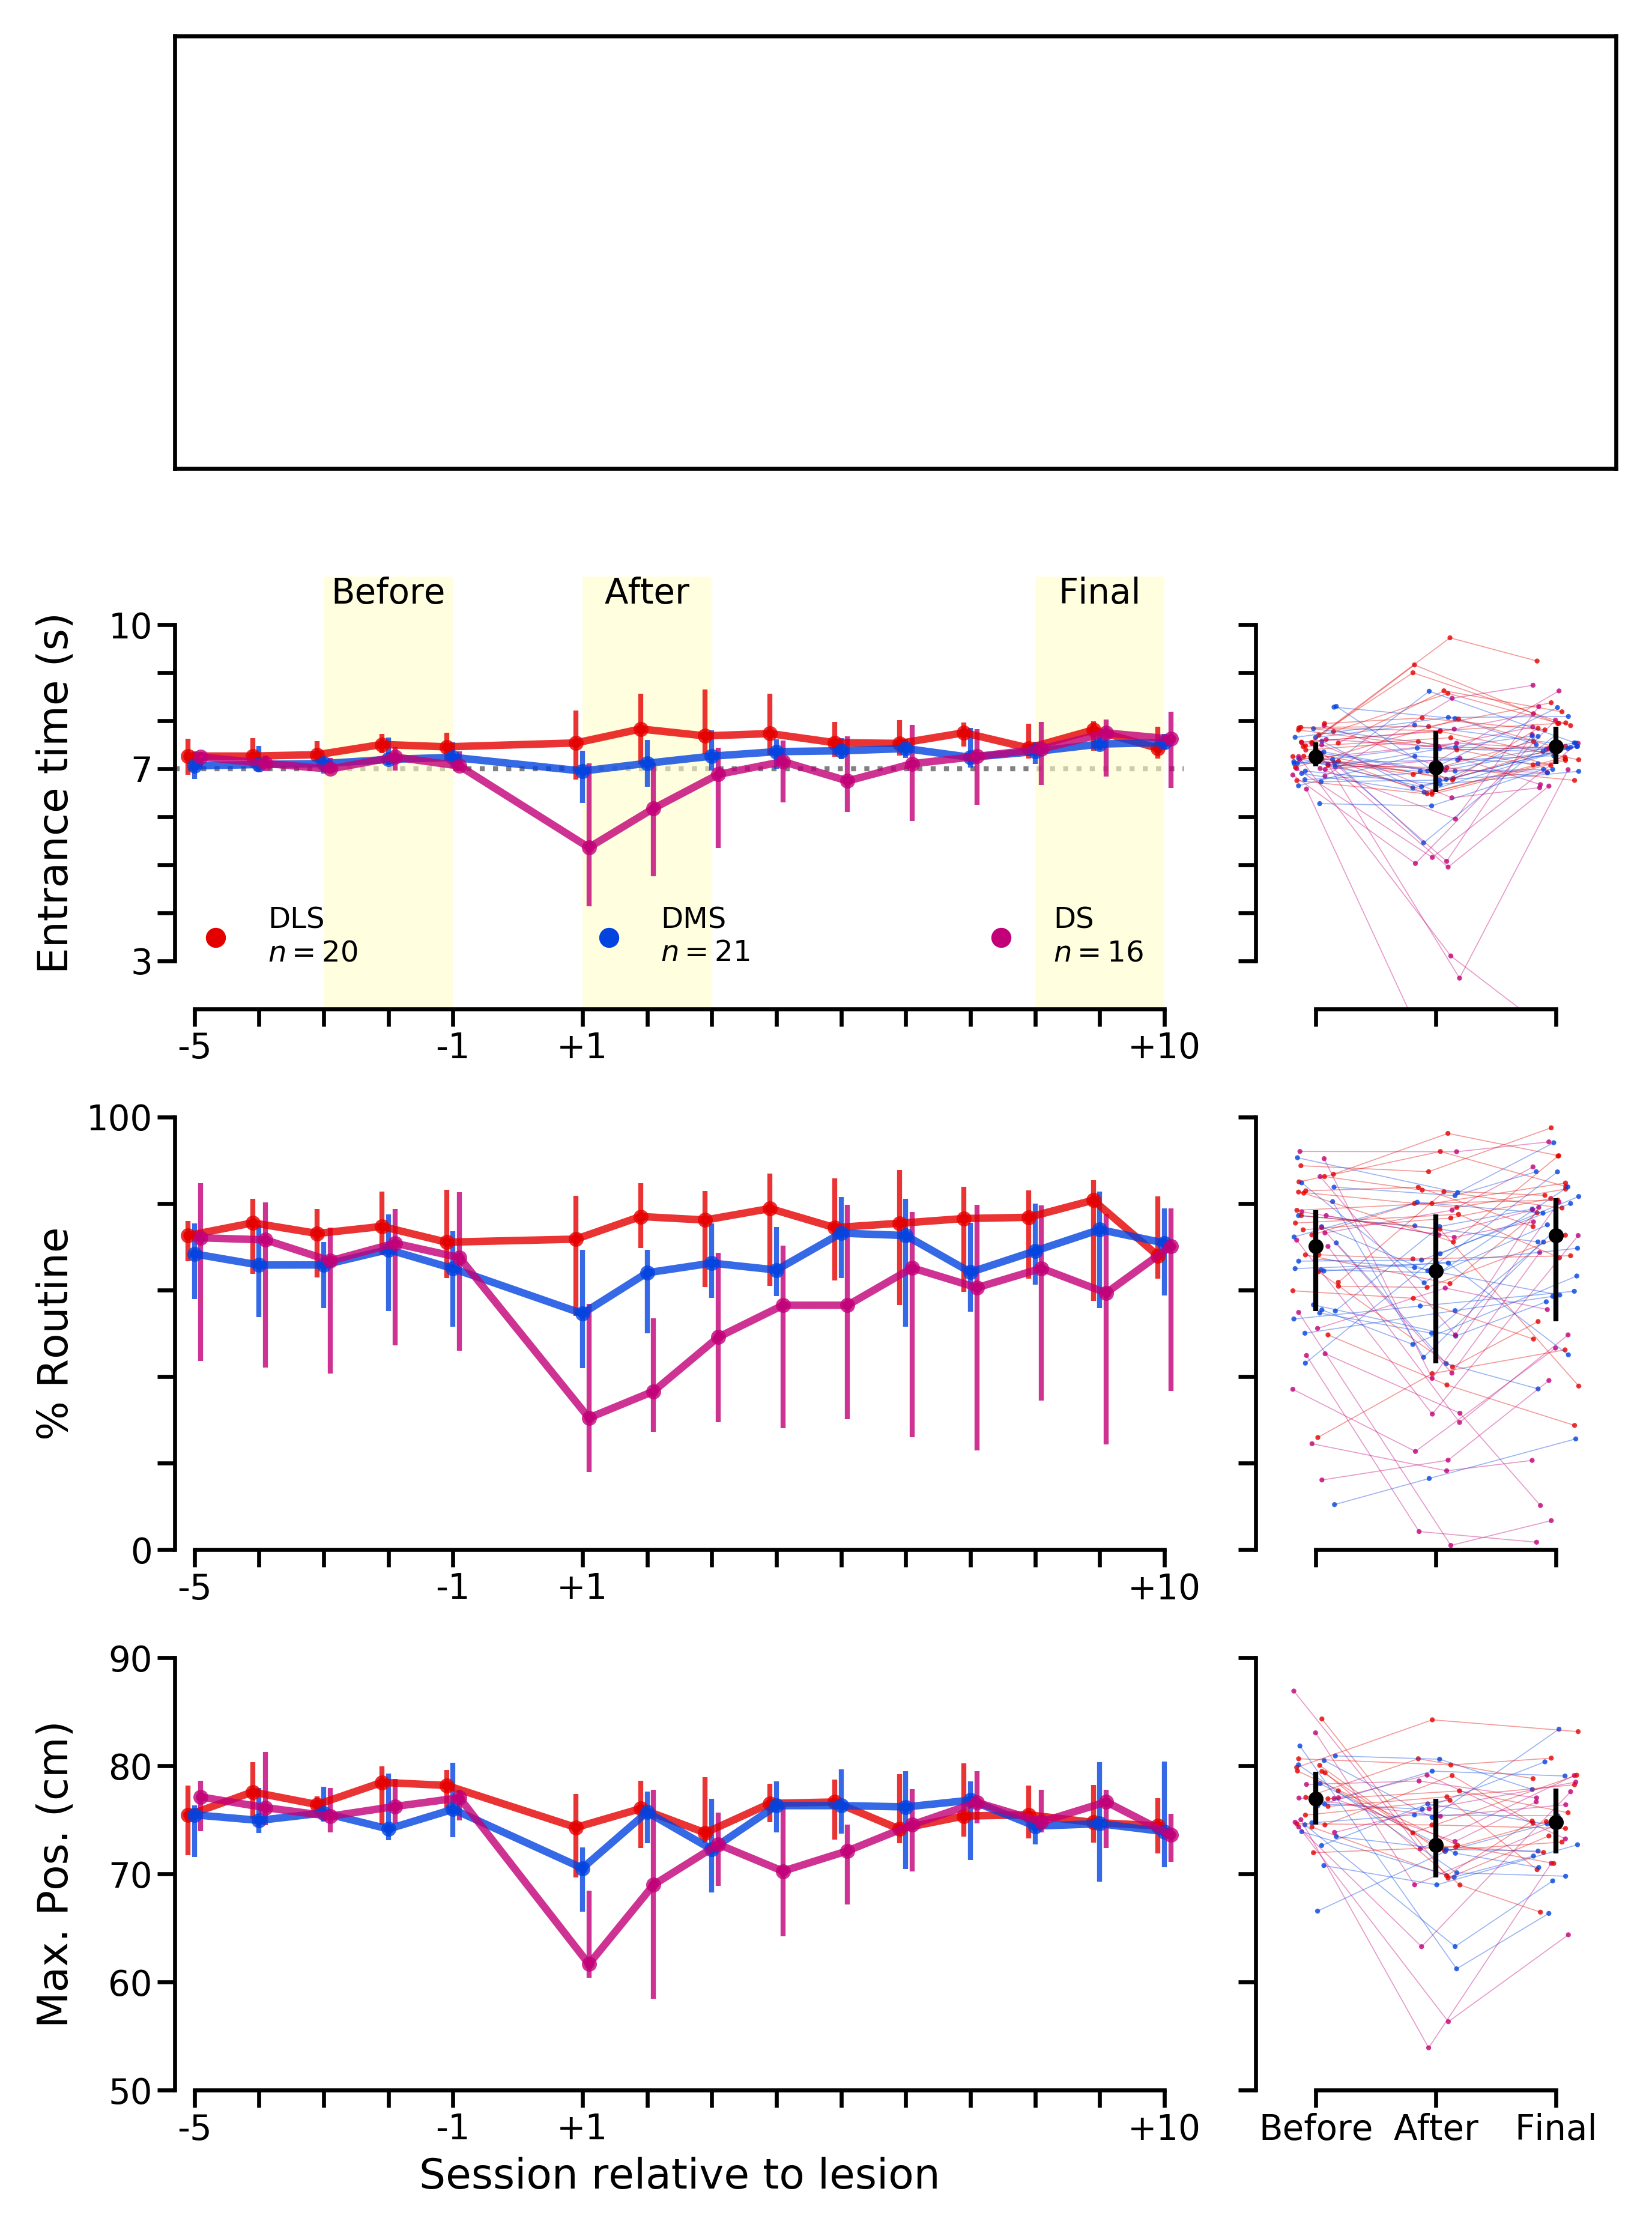

In [96]:
if "__file__" not in dir():
    plt.close('all')
    set_rc_params()
    figsize=(4,6)
    fig=plt.figure(figsize=figsize,dpi=600)
    

    ##########################################
    # 1: task rules
    gs1= fig.add_gridspec(nrows=1, ncols=1, left=0.0, bottom=0.8, right=1, top=1)
    ax1= fig.add_subplot(gs1[0])
    ax1.xaxis.set_visible(False)
    ax1.yaxis.set_visible(False)
#     ax1.spines['bottom'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
#     ax1.spines['right'].set_visible(False)
#     ax1.spines['top'].set_visible(False)
    
    
    
    
    ##########################################
    # 2: % entrance time time course
    gs2= fig.add_gridspec(nrows=1, ncols=1, left=0.0, bottom=0.55, right=0.7, top=.75)
    ax2= fig.add_subplot(gs2[0])
    
    #DLS
    xDLS2=plot_event_rec(root, ax2, ProfilesDLS2,TaskParamToPlot=TaskParamToPlot2,
                         nPre=nPre2, nPost=nPost2, color=DLSColor,shift=ShiftDLS2)

    #DMS
    xDMS2=plot_event_rec(root, ax2, ProfilesDMS2,TaskParamToPlot=TaskParamToPlot2,
                         nPre=nPre2, nPost=nPost2, color=DMSColor,shift=ShiftDMS2)

    #DS
    xDS2 =plot_event_rec(root, ax2, ProfilesDS2,TaskParamToPlot=TaskParamToPlot2,
                         nPre=nPre2, nPost=nPost2, color=DSColor,shift=ShiftDS2)

    
    add_legend_for_lesion_types(ax2,(len(xDLS2),len(xDMS2),len(xDS2)))
    
    ax2.axhline(y=7, ls=':',c='gray',lw=1, zorder=-5)
    ax2.set_ylim([2,11])
    ax2.spines['left'].set_bounds(3,10)
    ax2.set_yticks(np.arange(3,11))
    ax2.set_yticklabels([3,'','','',7,'','',10])
    ax2.set_ylabel('Entrance time (s)')
#     ax2.set_xticklabels([])

    plot_session_def(ax2,sessionSlices=(preSlice3,postSlice3,finSlice3))

    ##########################################
    # 3: ET event plot
    gs3= fig.add_gridspec(nrows=1, ncols=1, left=0.75, bottom=0.55, right=1, top=.75)
    ax3= fig.add_subplot(gs3[0])
    
    plot_event_1on1(root, ax3, Profiles3, colorCode=ColorCode, TaskParamToPlot=TaskParamToPlot2,
                    nPre=preSlice3, nPost=postSlice3,nFin=finSlice3)

    ax3.set_ylim([2,11])
    ax3.spines['left'].set_bounds(3,10)
    ax3.set_yticks(np.arange(3,11))
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    
    
    
    ##########################################
    # 4: % %Routine time course
    gs4= fig.add_gridspec(nrows=1, ncols=1, left=0.0, bottom=0.3, right=0.7, top=.5)
    ax4= fig.add_subplot(gs4[0])
    
    #DLS
    xDLS4=plot_event_rec(root, ax4, ProfilesDLS2,TaskParamToPlot=TaskParamToPlot4,
                         nPre=nPre2, nPost=nPost2, color=DLSColor,shift=ShiftDLS2)

    #DMS
    xDMS4=plot_event_rec(root, ax4, ProfilesDMS2,TaskParamToPlot=TaskParamToPlot4,
                         nPre=nPre2, nPost=nPost2, color=DMSColor,shift=ShiftDMS2)

    #DS
    xDS4 =plot_event_rec(root, ax4, ProfilesDS2,TaskParamToPlot=TaskParamToPlot4,
                         nPre=nPre2, nPost=nPost2, color=DSColor,shift=ShiftDS2)

    
    
    ax4.set_ylim([0,1])
    ax4.spines['left'].set_bounds(0,1)
    ax4.set_yticks(np.arange(0,1.1,.2))
    ax4.set_yticklabels([0]+['']*4+[100])
    ax4.set_ylabel('% Routine')
#     ax4.set_xticklabels([])
    
    
    
    ##########################################
    # 5: %Routine event plot
    gs5= fig.add_gridspec(nrows=1, ncols=1, left=0.75, bottom=0.3, right=1, top=.5)
    ax5= fig.add_subplot(gs5[0])
    
    plot_event_1on1(root, ax5, Profiles3, colorCode=ColorCode, TaskParamToPlot=TaskParamToPlot4,
                    nPre=preSlice3, nPost=postSlice3,nFin=finSlice3)

    ax5.set_ylim([0,1])
    ax5.spines['left'].set_bounds(0,1)
    ax5.set_yticks(np.arange(0,1.1,.2))
    ax5.set_yticklabels([])
    ax5.set_ylabel('')
    ax5.set_xticklabels([])
    
    
    
    ##########################################
    # 6: MaxPos time course
    gs6= fig.add_gridspec(nrows=1, ncols=1, left=0.0, bottom=0.05, right=0.7, top=.25)
    ax6= fig.add_subplot(gs6[0])
    
    #DLS
    xDLS6=plot_event_rec(root, ax6, ProfilesDLS2,TaskParamToPlot=TaskParamToPlot6,
                         nPre=nPre2, nPost=nPost2, color=DLSColor,shift=ShiftDLS2)

    #DMS
    xDMS6=plot_event_rec(root, ax6, ProfilesDMS2,TaskParamToPlot=TaskParamToPlot6,
                         nPre=nPre2, nPost=nPost2, color=DMSColor,shift=ShiftDMS2)

    #DS
    xDS6 =plot_event_rec(root, ax6, ProfilesDS2,TaskParamToPlot=TaskParamToPlot6,
                         nPre=nPre2, nPost=nPost2, color=DSColor,shift=ShiftDS2)

    
    ax6.set_ylim([50,90])
    ax6.spines['left'].set_bounds(50,90)
    ax6.set_yticks(np.arange(50,91,10))
    ax6.set_ylabel('Max. Pos. (cm)')
    ax6.set_xlabel('Session relative to lesion')
    

    
    ##########################################
    # 7: MaxPos event plot
    gs7= fig.add_gridspec(nrows=1, ncols=1, left=0.75, bottom=0.05, right=1, top=.25)
    ax7= fig.add_subplot(gs7[0])
    
    plot_event_1on1(root, ax7, Profiles3, colorCode=ColorCode, TaskParamToPlot=TaskParamToPlot6,
                    nPre=preSlice3, nPost=postSlice3,nFin=finSlice3)

    ax7.set_ylim([50,90])
    ax7.spines['left'].set_bounds(50,90)
    ax7.set_yticks(np.arange(50,91,10))
    ax7.set_yticklabels([])
    ax7.set_ylabel('')
    

    

    
    fig.align_ylabels([ax2,ax4,ax6])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(axes4[0],ax1,ax2,ax5,ax7,ax8,ax6)
#     OFFX=np.array([.07]*len(AXES))
#     OFFY=np.array([.01]*len(AXES))
#     OFFX[5]=0.03
#     OFFX[[0,1,2,4,6]]=0.05
    
#     add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(os.path.join(os.path.dirname(os.getcwd()),'LesionPaper','Figures','Task_Behavior.pdf'),
                format='pdf', bbox_inches='tight')
    
    plt.show()
    plt.close('all')
    matplotlib.rcdefaults()